In [14]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import logging

## Loading data

In [28]:
DATA_PATH = '../data/raw/'

# Create necessary directories
hackrf_path = os.path.join(DATA_PATH, 'hackrf')
input_path = '../data/processed/input'
os.makedirs(input_path, exist_ok=True)

folder_name = ['drone', 'nodrone']

sample_rate = 2e6 

## Plotting raw data

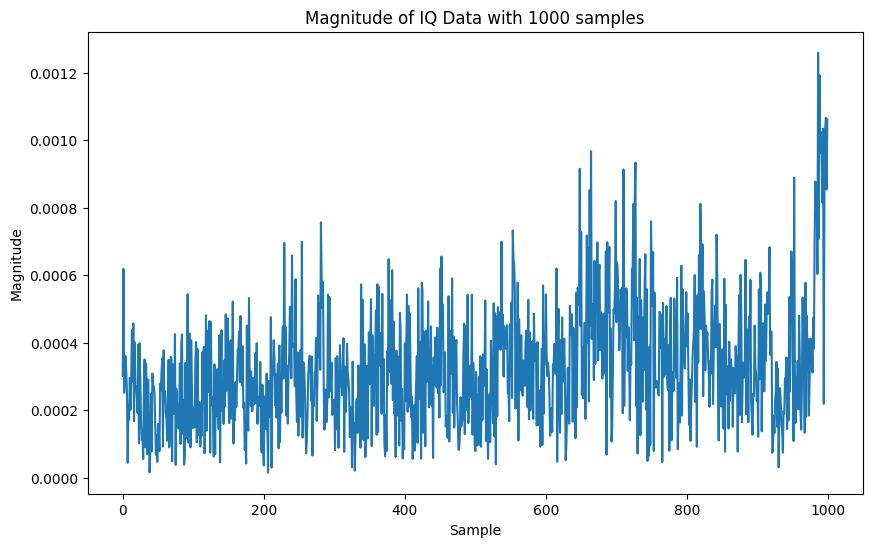

In [29]:
def plot_raw_data(file_path, samples=1000):
    iq_data = np.fromfile(file_path, dtype=np.complex64)
    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(iq_data[:samples]))
    plt.title(f"Magnitude of IQ Data with {samples} samples")
    plt.xlabel("Sample")
    plt.ylabel("Magnitude")
    plt.show()

plot_raw_data('../data/raw/hackrf/drone/15edd400-1ddb-416b-8327-a076f396b868_sweep.iq')

In [30]:
def compute_spectrogram_from_iq(file_path, sample_rate, segment_duration=1.0):
    iq_data = np.fromfile(file_path, dtype=np.complex64)
    segment_samples = int(sample_rate * segment_duration)
    data = np.abs(iq_data[:segment_samples])
    data = librosa.util.normalize(data)
    
    N = int(32e-3 * sample_rate)
    hop_length = N // 2
    S = librosa.stft(data, n_fft=N, hop_length=hop_length, window='hann')
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    return S_db

S_db = compute_spectrogram_from_iq('../data/raw/hackrf/drone/15edd400-1ddb-416b-8327-a076f396b868_sweep.iq', sample_rate=sample_rate)
print(f"S_db shape: {S_db.shape}")
print(f"S_db min: {np.min(S_db)}, max: {np.max(S_db)}")


S_db shape: (32001, 5)
S_db min: -80.0, max: 0.0


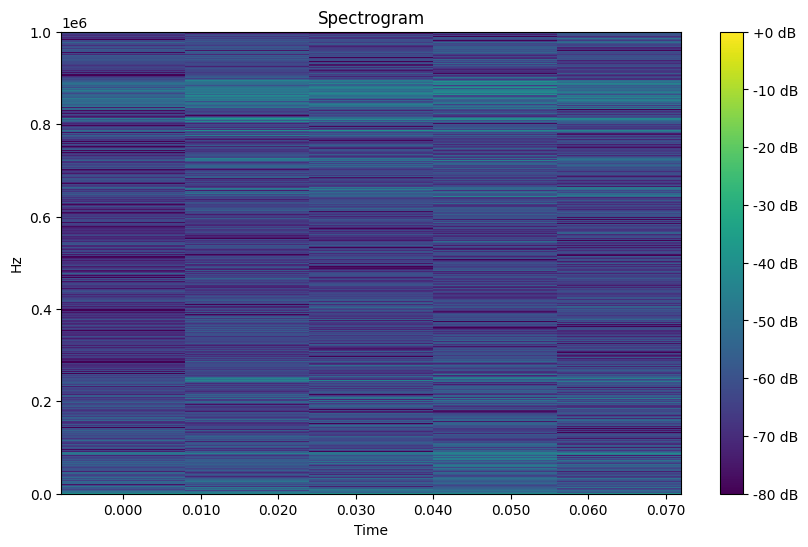

In [31]:
N = int(32e-3 * sample_rate)
hop_length = N // 2

plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

## Converting into spectrograms

Here, we use the librosa library to scale the data, perform short-time Fourier Transform, and develop spectrograms for each segment. We use the 'hamming' window to smooth the edges of each chunk to avoid artifacts. The amplitudes of the frequency is then converted to decibels.

In [16]:
def create_spectrogram(file_path, export_path, segment_duration=1.0, img_size=128):
    iq_data = np.fromfile(file_path, dtype=np.complex64)
    
    # number of samples for specified segment duration
    segment_samples = int(sample_rate * segment_duration)

    # Using magnitude of complex IQ data
    data = np.abs(iq_data[:segment_samples])

    # Normalize data
    data = librosa.util.normalize(data)
    
    # Compute spectrogram
    N = int(32e-3 * sample_rate)
    hop_length = N // 2  # 50% overlap
    S = librosa.stft(data, n_fft=N, hop_length=hop_length, window='hamming')
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    # Plot spectrogram
    fig, ax = plt.subplots(figsize=(img_size/100, img_size/100))
    img = librosa.display.specshow(S_db, sr=sample_rate, hop_length=hop_length, x_axis=None, y_axis=None, ax=ax, cmap='gray_r')
    
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(export_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    
    with Image.open(export_path) as img:
        print(f"Image shape for {os.path.basename(export_path)}: {img.size}")

In [18]:
for folder in os.listdir(hackrf_path):
    folder_path = os.path.join(hackrf_path, folder)

    if not os.path.isdir(folder_path):
        continue
    
    export_path = os.path.join(input_path, folder)
    os.makedirs(export_path, exist_ok=True)
    
    for file in os.listdir(folder_path):
        if file.endswith('.iq'):
            file_path = os.path.join(folder_path, file)
            export_file = os.path.join(export_path, f"{os.path.splitext(file)[0]}.png")
            create_spectrogram(file_path, export_file, sample_rate)

print("Spectrograms created successfully.")

/opt/miniconda3/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1280000 is too large for input signal of length=150000
  warnings.warn(


Image shape for 65d801b8-9b19-40b4-b0a7-ee00d4f95fe2_sweep.png: (128, 128)
Image shape for 136028d4-b4cf-4690-8ce8-d6e78e02baa6_sweep.png: (128, 128)
Image shape for 2ee1c096-4b9e-4d9a-8df8-68e7a3fb492e_sweep.png: (128, 128)
Image shape for 3cf512d4-b058-4ce6-84ca-cfa7a59fc8eb_sweep.png: (128, 128)
Image shape for 855c4f03-5400-4f34-9be9-f9b004fba0a4_sweep.png: (128, 128)
Image shape for 66c1523b-43e4-4b28-88d7-39693c82c69f_sweep.png: (128, 128)
Image shape for 1eafae12-3d15-4059-8acb-8400203b6f57_sweep.png: (128, 128)
Image shape for c2e390a4-4033-4e35-be2d-22b1fc370ea6_sweep.png: (128, 128)
Image shape for 4c924b88-302e-41b0-b6c5-83083233db1d_sweep.png: (128, 128)
Image shape for 843ccff3-7a48-4b82-89a2-cdf73bd7f44f_sweep.png: (128, 128)
Image shape for 79c36e04-a58f-4f67-9054-6a0c624b7858_sweep.png: (128, 128)
Image shape for 4ed46cad-f3e1-4d64-8de4-ef60c5cb3c6e_sweep.png: (128, 128)
Image shape for ccf9048c-2a79-4640-8b2c-74b5a8195d80_sweep.png: (128, 128)
Image shape for c6f96060-

## Spectrograms to feature matrix for models

In [25]:
def standardize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

Opens spectrogram images and converts into grayscale (just to make sure). These images are then rotated 270 degrees, min-max normalized, and reshaped to a 1D array. All these flattened images are stacked on top of each other to build our feature matrix.

In [26]:
X_list = []
y = []

for drone in ['ar', 'bepop', 'bg', 'phantom']:
    pngs_path = os.path.join(input_path, drone)
    if not os.path.exists(pngs_path):
        print(f"Warning: Directory not found: {pngs_path}")
        continue
    
    drone_pngs_path = [os.path.join(pngs_path, f) for f in os.listdir(pngs_path) if f.endswith('.png')]
    
    for png_path in drone_pngs_path:
        img = np.array(Image.open(png_path).convert('L'))
        x = np.rot90(img, k=3)  # rotate
        x = standardize(x)
        x = x.reshape(1, IMG_SIZE*IMG_SIZE)
        
        X_list.append(x)
        y.append(drone)

X = np.vstack(X_list)
X = pd.DataFrame(X, columns=[f'p{i+1}' for i in range(IMG_SIZE*IMG_SIZE)])
df = pd.concat([pd.DataFrame({'y': y}), X], axis=1)

## PCA

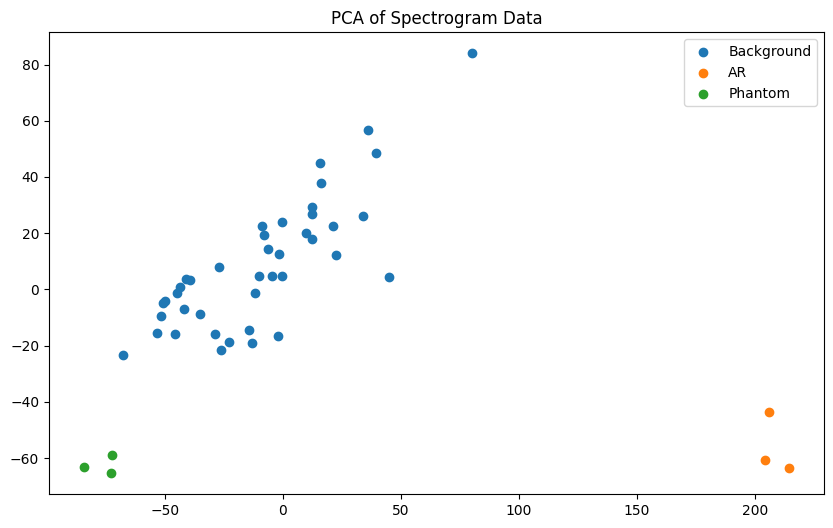

In [27]:
from sklearn.decomposition import PCA

pca_df = df.copy()
label_mapping = {'bg': 0, 'ar': 1, 'phantom': 2}
pca_df['y'] = pca_df['y'].map(label_mapping)

X = pca_df.drop(['y'], axis=1)
y = pca_df['y']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Background')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='AR')
plt.scatter(X_pca[y == 2, 0], X_pca[y == 2, 1], label='Phantom')
plt.legend()
plt.title('PCA of Spectrogram Data')
plt.show()

There is clear separation between each drone and background points.

## Split data into training and testing

For anomaly detection cases, we don't care about specific drones quite yet. Due to this, we map every drone label as a "drone" with label 1.

In [28]:
df['y'] = df['y'].map(lambda x: 0 if x == 'bg' else 1)

X = df.drop(['y'], axis=1)
y = df['y']

X_bg = X[y == 0]
X_drone = X[y == 1]

# Split background data into train and test sets
X_bg_train, X_bg_test = train_test_split(X_bg, test_size=0.2, random_state=42)

# Use all drone data and some background data for testing
X_test = pd.concat([X_bg_test, X_drone])
y_test = pd.concat([pd.Series([0] * len(X_bg_test)), pd.Series([1] * len(X_drone))])

print("Full dataset distribution:")
print(y.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

Full dataset distribution:
y
0    0.87234
1    0.12766
Name: proportion, dtype: float64

Test set distribution:
0    0.6
1    0.4
Name: proportion, dtype: float64


## Z-score for anomaly detection (current implementation)

In [29]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [30]:
def z_score_anomaly_detector(X_train, X_test, threshold=3):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_bg_train)
    X_test_scaled = scaler.transform(X_test)
    
    mean = np.mean(X_train_scaled, axis=0)
    std = np.std(X_train_scaled, axis=0)

    z_scores = np.abs((X_test_scaled - mean) / std)

    # Flag as anomaly if any feature's z-score exceeds the threshold
    max_z_scores = np.max(z_scores, axis=1)
    return max_z_scores, pd.Series(np.where(max_z_scores > threshold, 1, 0))

In [31]:
import warnings
warnings.filterwarnings('ignore')

thresholds = [3, 3.5, 4, 4.5, 5]
for threshold in thresholds:
    z_scores, y_pred = z_score_anomaly_detector(X_bg_train, X_test, threshold=threshold)
    print(f"Results with threshold {threshold}:")
    print(classification_report(y_test, y_pred))

Results with threshold 3:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.40      1.00      0.57         6

    accuracy                           0.40        15
   macro avg       0.20      0.50      0.29        15
weighted avg       0.16      0.40      0.23        15

Results with threshold 3.5:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.40      1.00      0.57         6

    accuracy                           0.40        15
   macro avg       0.20      0.50      0.29        15
weighted avg       0.16      0.40      0.23        15

Results with threshold 4:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.40      1.00      0.57         6

    accuracy                           0.40        15
   macro avg       0.20      0.50      0.29     

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.50      1.00      0.67         6

    accuracy                           0.60        15
   macro avg       0.75      0.67      0.58        15
weighted avg       0.80      0.60      0.57        15



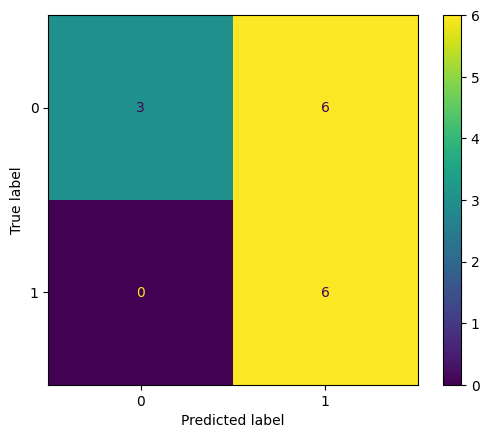

In [32]:
z_scores, y_pred = z_score_anomaly_detector(X_bg_train, X_test, threshold=5)
print(classification_report(y_test, y_pred))
disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# Isolation forest

In [33]:
from sklearn.ensemble import IsolationForest

Contamination level is basically the percent of anomalies expected.

In [35]:
iso_forest = IsolationForest(contamination=0.14)
iso_forest.fit(X_bg_train)

IsolationForest(contamination=0.14)

In [36]:
iso_forest.get_params()

{'bootstrap': False,
 'contamination': 0.14,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [37]:
y_pred_iso = iso_forest.predict(X_test)

In [38]:
print(y_pred_iso)

[ 1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


In [39]:
test_iso_predictions = (y_pred_iso == -1).astype(int)

In [40]:
def evaluate_predictions(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Confusion Matrix:


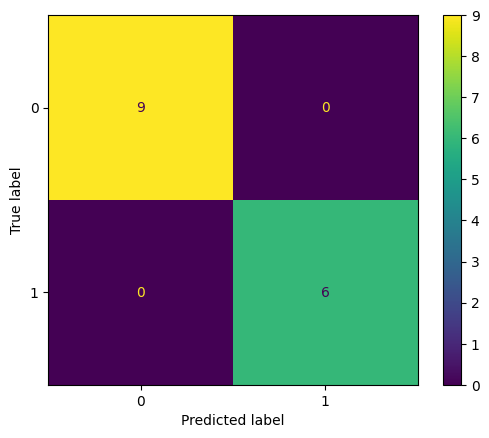

In [41]:
evaluate_predictions(y_test, test_iso_predictions)

### Using custom threshold with isolation forest anomaly scores

The decision function computes the anomaly score for each sample. The decision score is based on the average path length to isolate a sample. This was just for me to understand the how contamination and the decision function worked.

In [42]:
# Get anomaly scores
train_iso_scores = iso_forest.decision_function(X_bg_train)
test_iso_scores = iso_forest.decision_function(X_test)

In [43]:
threshold = np.percentile(train_iso_scores, 10)  # bottom 10% as anomalies
custom_iso_predictions = np.where(test_iso_scores < threshold, 1, 0)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Confusion Matrix:


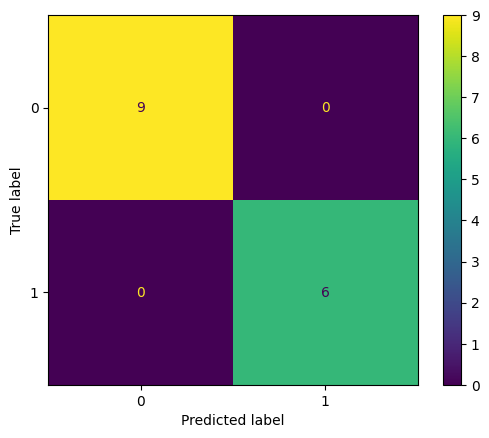

In [44]:
evaluate_predictions(y_test, custom_iso_predictions)

## Local Outlier Factor (LOF)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(contamination=0.1, novelty=True)
lof.fit(X_bg_train)

In [ ]:
y_pred_lof = lof.predict(X_test)

In [ ]:
print(y_pred_lof)

In [ ]:
test_lof_predictions = (y_pred_lof == -1).astype(int)
print(test_lof_predictions)

In [ ]:
evaluate_predictions(y_test, test_lof_predictions)

## Cross validation

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

def custom_cross_validation(X, y, n_splits=5):
    # Separate background and drone data
    X_bg = X[y == 0]
    X_drone = X[y == 1]
    y_bg = y[y == 0]
    y_drone = y[y == 1]

    # Create stratified k-fold for background data
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X_bg, y_bg), 1):
        # Split background data
        X_bg_train, X_bg_val = X_bg.iloc[train_index], X_bg.iloc[val_index]
        
        # Combine validation background data with all drone data for testing
        X_val = pd.concat([X_bg_val, X_drone])
        y_val = pd.concat([pd.Series([0] * len(X_bg_val)), pd.Series([1] * len(X_drone))])
        
        # Train Isolation Forest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        iso_forest.fit(X_bg_train)
        
        # Predict anomaly scores
        anomaly_scores = -iso_forest.decision_function(X_val)
        
        # Calculate AUC-ROC score
        auc_score = roc_auc_score(y_val, anomaly_scores)
        scores.append(auc_score)
        
        print(f"Fold {fold} AUC-ROC: {auc_score:.3f}")
    
    print(f"\nMean AUC-ROC: {np.mean(scores):.3f} (+/- {np.std(scores) * 2:.3f})")
    
    return scores
cv_scores = custom_cross_validation(X, y)

In [ ]:
import sys
import numpy as np
import pandas as pd
import sklearn
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")